In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
dataset_train = pd.read_csv('Google_Stock_Price_Train.csv')
# 개장 열만 추출
training_set = dataset_train.iloc[:, 1:2].values

In [6]:
# RNN을 구축할 때 마다 활성화 함수로 시그모이드 함수가 존재할 때 정규화가 더 용이하다.
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [7]:
# 0~1로 정규화된 모습
training_set_scaled

array([[0.08581368],
       [0.09701243],
       [0.09433366],
       ...,
       [0.95725128],
       [0.93796041],
       [0.93688146]])

### 타임스텝 만들기

In [8]:
# 주식은 한 달에 20번 있으므로 3개월 전까지 즉, 60개의 타임스텝을 만들어본다.
X_train = [] # 60개의 주가
y_train = [] # 다음 주식시장의 주가
for i in range(60, 1258):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [9]:
# 3차원으로 배열을 해야한다.
# 관측치 수: 주가의 총 개수
# 타입스탭의 수: 60개 X_train의 열 개수
# 예측 변수에 해당하는 차원: 지표 수
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# RNN 구현

In [10]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [11]:
# 주가라는 연속된 출력을 예측하기 때문에 ANN, CNN과 달리 회귀를 이용한다.
regressor = Sequential()

### LSTM, 드롭아웃 정규화 추가하기

In [12]:
# 뉴런 수 50개, 반환 시퀀스 인수 True
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2)) # 과적합 방지

In [13]:
# 2번째
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2)) 
# 3번째
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2)) 
# 4번째 
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2)) 

### 출력층 만들기

In [14]:
regressor.add(Dense(units = 1))

RNN에서 옵티마이저는 크게 RMSProp, Adam이 있다.

Adam이 Momentum과 RMSProp이 합쳐진 형태로

일반적 알고리즘에서 현재 가장 많이 사용되고 있다.

In [15]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

### 에포크

In [16]:
# 반복횟수인 100번의 에포크와 32개의 배치크기를 설정.
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
38/38 [==============================] - 10s 71ms/step - loss: 0.0368
Epoch 2/100
38/38 [==============================] - 3s 70ms/step - loss: 0.0071
Epoch 3/100
38/38 [==============================] - 3s 69ms/step - loss: 0.0056
Epoch 4/100
38/38 [==============================] - 3s 75ms/step - loss: 0.0057
Epoch 5/100
38/38 [==============================] - 3s 77ms/step - loss: 0.0051
Epoch 6/100
38/38 [==============================] - 3s 71ms/step - loss: 0.0052
Epoch 7/100
38/38 [==============================] - 3s 66ms/step - loss: 0.0043
Epoch 8/100
38/38 [==============================] - 2s 61ms/step - loss: 0.0045
Epoch 9/100
38/38 [==============================] - 2s 61ms/step - loss: 0.0054
Epoch 10/100
38/38 [==============================] - 2s 62ms/step - loss: 0.0046
Epoch 11/100
38/38 [==============================] - 2s 63ms/step - loss: 0.0045
Epoch 12/100
38/38 [==============================] - 3s 71ms/step - loss: 0.0041
Epoch 13/100
38/38 [====

0.1%의 손실률을 보였다.

# 예측 및 시각화

In [17]:
# 2017년 주가 데이터 가져오기
dataset_test = pd.read_csv('Google_Stock_Price_Test.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values

In [19]:
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 80):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

1/1 [==============================] - 2s 2s/step


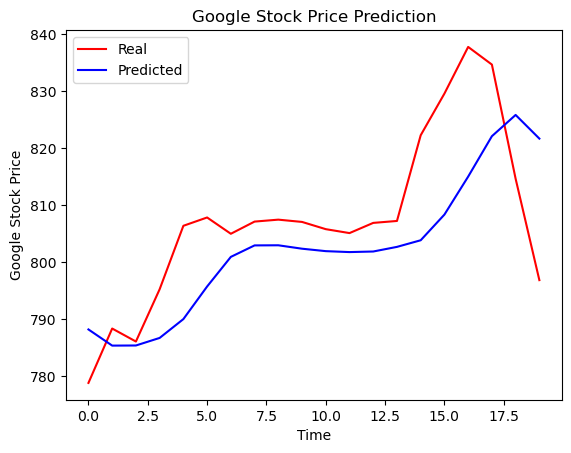

In [24]:
plt.plot(real_stock_price, color = 'red', label = 'Real')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

# 결론

실제 값과 예측 값의 흐름이 비슷했다. 

그러나, 빠르고 비선형적인 변화에 따라갈 수 없기 때문에 주식이 폭등하는 부분에서는 예측 값이 따르지 못했다. 

모델 예측력을 향상 시키려면 

1. 데이터 더 모으기
2. 3개월 타임스텝을 더 길게 늘리기
3. 구글 주가와 높은 상관관계를 가지고 있는 타 주가 지쵸를 추가하기
4. LSTM 추가하기
5. 뉴런 추가하기

등이 있다. 다른 프로젝트를 진행할 때 참고해서 시도해야겠다.